In [1]:
%load_ext autoreload
%autoreload 2

from compas.geometry import Box, Frame, Translation, Rotation
from compas_assembly.datastructures import Block as CRA_Block
from compas_cra.datastructures import CRA_Assembly
from compas_cra.algorithms import assembly_interfaces_numpy
from compas_cra.equilibrium import cra_solve, cra_penalty_solve, rbe_solve
from compas_cra.viewers import cra_view

from tqdm.auto import tqdm

from assembly_gym.utils.rendering import plot_cra_assembly

import matplotlib.pyplot as plt
import numpy as np

from assembly_gym.envs.assembly_env import AssemblyEnv, Shape, Block
from assembly_gym.envs.gym_env import AssemblyGym, sparse_reward, tower_setup, bridge_setup, hard_tower_setup, Action

from assembly_gym.utils.geometry import align_frames_2d, maximum_tension
from assembly_gym.utils.rendering import plot_assembly_env, render_assembly_env, plot_block_movements

# suppress warnings
import warnings
import logging
import compas

pybullet build time: May 28 2024 09:55:49


# a small setup as described in the tutorial

Number of interfaces: 1


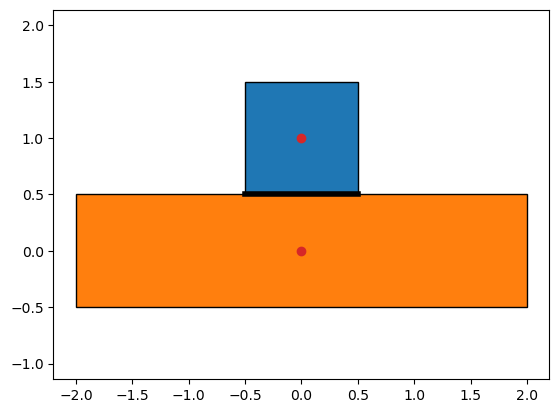

In [2]:
# create a small setup as described in the tutorial
# https://blockresearchgroup.github.io/compas_cra/latest/tutorial.html

support = Box(4, 2, 1, frame=Frame.worldXY())  # supporting block

x_offset = 0. 
# x_offset = 2.0 
# x_offset = 2.1 # the top block should start falling
free1 = Box(1, 3, 1, frame=Frame.worldXY().transformed( Translation.from_vector([x_offset, 0, 1])))  # block to analyse
assembly = CRA_Assembly()  # create empty assembly
assembly.add_block(CRA_Block.from_shape(support), node=0)  # add support to assembly
assembly.add_block(CRA_Block.from_shape(free1), node=1)  # add block to assembly

# "freeze" the support block
assembly.set_boundary_conditions([0])  # set support as boundary condition
assembly_interfaces_numpy(assembly)  # identify interface between two blocks

# a lot of information is stored in assembly.graph, e.g.
print(f"Number of interfaces: {assembly.graph.number_of_edges()}")

# plot 2d projection (forces are not yet computed)
fig, ax = plot_cra_assembly(assembly, plot_forces=False)

Aeq:  (6, 12)
Afr:  (32, 12)
1.0
1.0
--- set up time: 0.0064849853515625 seconds ---
finished setup... now trying to solve it...
Ipopt 3.14.16: tol=1e-10
constr_viol_tol=1e-12
compl_inf_tol=1e-12
acceptable_tol=1e-08
acceptable_constr_viol_tol=1e-08
acceptable_compl_inf_tol=1e-08


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:       92
Number of nonzeros in inequality constraint Jacobian.:      128
Number of nonzeros in Lagrangian Hessian.............:       40

Total number of variables............................:       22
  

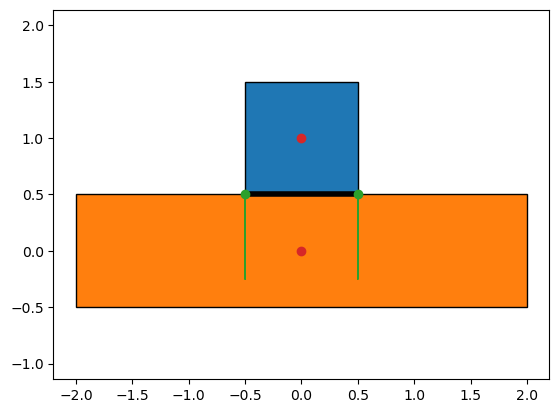

In [3]:
# stability algorithm:
# fails to find a solution if it is not stable
res = cra_solve(assembly, verbose=True, timer=True)  # solve equilibrium using cra_solve
fig, ax = plot_cra_assembly(assembly, plot_forces=True)

Compression: 0.75
Compression: 0.75
Compression: 0.75
Compression: 0.75


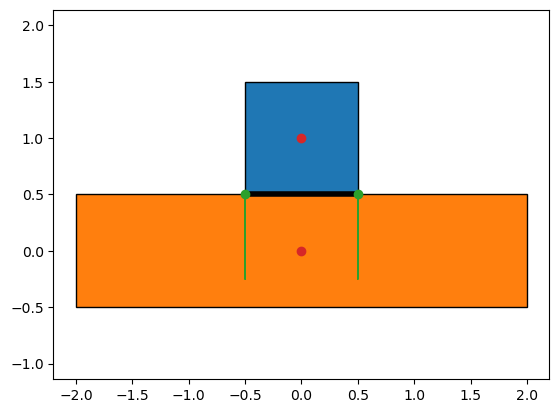

In [4]:
# this version of the stability algorithm always find a solution, and computes "tension" forces that identify instability
# cra_penalty_solve(assembly, verbose=True, timer=True)  # solve equilibrium using cra_solve
fig, ax = plot_cra_assembly(assembly, plot_forces=True)


def print_force_information(assembly):
    for edge in assembly.graph.edges():
        interfaces = assembly.graph.edge_attribute(edge, "interfaces")
        for interface in interfaces:
            # print(interface.forces)

            n = len(interface.points)
            for i in range(n):
                    force = interface.forces[i]
                    # note: positive force is compression, negative force is tension (instability)
                    normal_force = force['c_np']  - force['c_nn']
                    print("Compression:" if normal_force > 0 else "Tension:", normal_force)


print_force_information(assembly)

# Transfer Blocks from our Assembly Environment to the CRA Assembly Environment

argv[0]=
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.14.16\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
{'last_block': Block (2), 'collision': False, 'collision_info': {'obstacles': [], 'blocks': [], 'floor': False, 'bounding_box': False}, 'frozen_block': None, 'stable': False, 'stability_info': None}
{'last_block': Block (3), 'collision': False, 'collision_info': {'obstacles': [], 'blocks': [], 'floor': False, 'bounding_box': False}, 'frozen_block': None, 'stable': True, 'stability_info': None}


Text(0.5, 1.0, 'Our Assembly Environment')

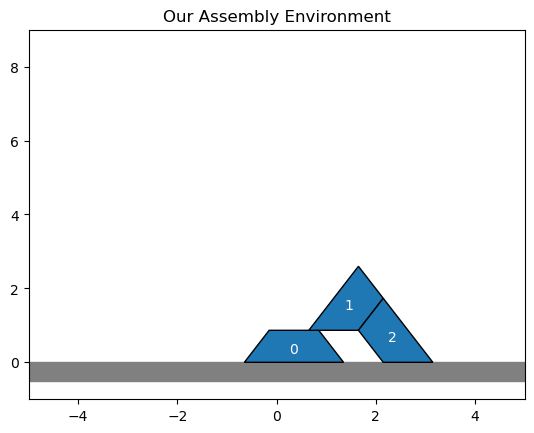

In [5]:
# load shapes
trapezoid = Shape(urdf_file='shapes/trapezoid.urdf')
vblock = Shape(urdf_file='shapes/v_block.urdf')
cube = Shape(urdf_file='shapes/cube.urdf')
# cube = Shape(urdf_file='shapes/small_cube.urdf')
tblock = Shape(urdf_file='shapes/t_block.urdf')

trapezoid.num_faces_2d, trapezoid.urdf_file

env = AssemblyEnv(render=False)

env.reset()
shape = trapezoid


# place first block on floor
position, rotation = align_frames_2d(env.get_floor_frame(), shape.get_face_frame_2d(face=3), frame1_coordinates=[0.35, 0, 0])

block1 = Block(shape=shape, position=position, orientation=rotation.quaternion)
env.add_block(block1)

# add second block
position, rotation = align_frames_2d(block1.get_face_frame_2d(face=1), trapezoid.get_face_frame_2d(face=2), frame1_coordinates=[0.8, 0.0, 0])
block2 = Block(shape=trapezoid, position=position, orientation=rotation.quaternion)
print(env.add_block(block2))


# add third block
#contact point of block 2 (just for plotting):
p2 = block2.get_face_frame_2d(1).to_world_coordinates([-0.0, 0, 0])
position, rotation = align_frames_2d(block2.get_face_frame_2d(face=1), trapezoid.get_face_frame_2d(face=2), frame1_coordinates=[-0.0, 0.0, 0])
# position, rotation = align_frames_2d(env.get_floor_frame(), trapezoid.get_face_frame_2d(2), frame1_coordinates=[0.2, 0.0, 0])
block3 = Block(shape=trapezoid, position=position, orientation=rotation.quaternion)
print(env.add_block(block3))

# # add another block on the floor, in a collision position
# position, rotation = align_frames_2d(env.get_floor_frame(), trapezoid.get_face_frame_2d(face=2), frame1_coordinates=[0.45, 0.0, -0.01])
# block4 = Block(base_block=trapezoid, position=position, orientation=rotation.quaternion)
# print(env.add_block(block4))

fig, ax = plot_assembly_env(env)
ax.set_title("Our Assembly Environment")

Number of interfaces: 4


Text(0.5, 1.0, 'Assembly CRA Environment')

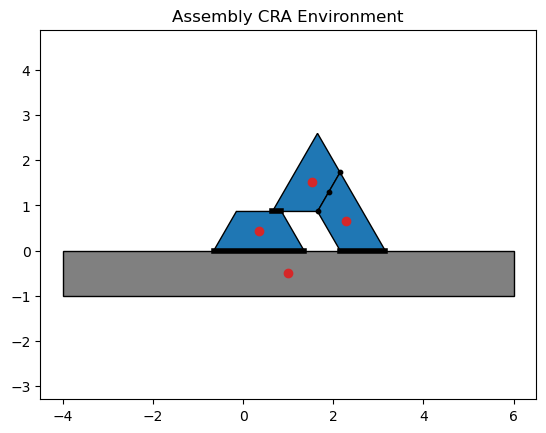

In [6]:
assembly = CRA_Assembly()  # create empty assembly

# create a support block
thickness=1.
support = Box(10, 10, thickness, frame=Frame.worldXY().transformed( Translation.from_vector([1., 1., -thickness/2]))) 
assembly.add_block(CRA_Block.from_shape(support), node=-1)  # add support to assembly
assembly.set_boundary_conditions([-1])  # set support as boundary condition

# add blocks to assembly
assembly.add_block_from_mesh(block1.mesh, node=0)
assembly.add_block_from_mesh(block2.mesh, node=1)
assembly.add_block_from_mesh(block3.mesh, node=2)

# compute interfaces
assembly_interfaces_numpy(assembly, amin=0.001)  # identify interface between two blocks

print(f"Number of interfaces: {assembly.graph.number_of_edges()}")
fig, ax = plot_cra_assembly(assembly, plot_forces=False)
ax.set_title("Assembly CRA Environment")

Aeq:  (18, 54)
Aeq:  (18, 72)
Afr:  (144, 72)
0.1
0.1
0.1
0.1
--- set up time: 0.008980989456176758 seconds ---
finished setup... now trying to solve it...
Ipopt 3.14.16: tol=1e-08
constr_viol_tol=1e-07
acceptable_tol=1e-06
acceptable_constr_viol_tol=1e-05


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:     1068
Number of nonzeros in inequality constraint Jacobian.:      840
Number of nonzeros in Lagrangian Hessian.............:      368

Total number of variables............................:      108
                     varia

(<Figure size 640x480 with 1 Axes>, <Axes: >)

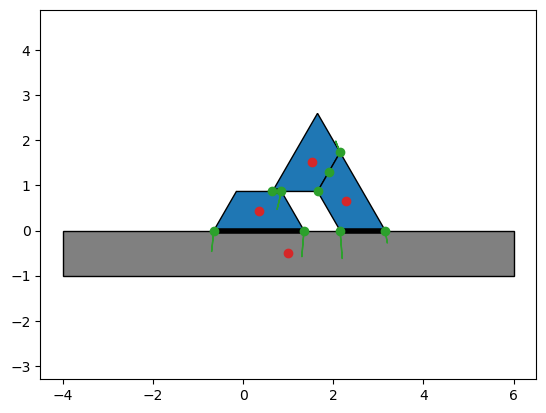

In [7]:
# stability computation
mu = 0.8
density = 0.1
d_bnd = 0.05
eps=0.0001

# solver 1: cra_solve
# cra_solve(assembly, mu=mu, d_bnd=d_bnd, eps=eps, density=density, verbose=True, timer=True) 

# solver 2: cra_penalty_solve
cra_penalty_solve(assembly, mu=mu, d_bnd=d_bnd, eps=eps, density=density, verbose=True, timer=True) 

# solver 3: rbe_solve
# rbe_solve(assembly, mu=mu, penalty=False, density=density, verbose=True, timer=True)

# solver 4: rbe_solve with penalty
# rbe_solve(assembly, mu=mu, penalty=True, density=density, verbose=True, timer=True) 


print_force_information(assembly)

plot_cra_assembly(assembly, plot_forces=True, force_scale=10)

In [8]:
RESULTS = dict()

In [9]:


# suppress warnings
import warnings
import logging
warnings.filterwarnings("ignore")
logging.disable(logging.WARNING)


def stability_benchmark(assembly, mus, density=0.1, d_bnd=0.05, solver_options=None, eps=0.0001):
    results = dict()
    for mu in mus:
        results[mu] = dict()
        try:
            cra_penalty_solve(assembly, mu = mu, density=density, d_bnd=d_bnd, eps=eps, verbose=False, timer=False, solver_options=solver_options)
            mt = maximum_tension(assembly)
            results[mu]["cra_penalty"] = mt
        except ValueError as e:
            results[mu]["cra_penalty"] = str(e.args[0])

        try:
            rbe_solve(assembly, mu = mu, density=density, penalty=True, verbose=False, timer=False, solver_options=solver_options)
            mt = maximum_tension(assembly)
            results[mu]["rbe_penalty"] = mt
        except ValueError as e:
            results[mu]["rbe_penalty"] = str(e.args[0])
        
        try:
            results[mu]["cra"] = "feasible"
            cra_solve(assembly, mu = mu, density=density, d_bnd=d_bnd, eps=eps, verbose=False, timer=False, solver_options=solver_options)
        except ValueError as e:
            results[mu]["cra"] = str(e.args[0])
        try:
            results[mu]["rbe"] = "feasible"
            rbe_solve(assembly, mu = mu, density=density, penalty=False, verbose=False, timer=False, solver_options=solver_options)
        except ValueError as e:
            results[mu]["rbe"] = str(e.args[0])

    return results
    # print(f"mu={mu}, density={density}, rbe={feasbile2}, cra={feasbile}, cra_penalty={mt}")



In [10]:
def plot_result(data, method, ax1, ax2, color, offset=0.0):
    # for density, data in results.items():
    x1 = []
    x2 = []
    y1 = []
    y2 = []
    for mu, result in data.items():
        res = result[method]

        x2.append(mu)
        if res == 'infeasible':
            y2.append(1)
        elif res == 'maxIterations':
            y2.append(0.66)
        elif res == 'Cannot load a SolverResults object with bad status: error':
            y2.append(0.33)
        elif res == 'feasible' or not isinstance(res, str):
            y2.append(0)
        else:
            raise ValueError(f"Unknown result: {res}")
        if isinstance(res, float):
            x1.append(mu)
            y1.append(res)


    ax1.plot(x2, np.array(y2) + offset, marker='o', label=f"{method}", color=color)
    if len(x1) > 0:
        ax2.plot(x1, y1, marker='o', label=f"{method}", color=color)
    # ax.plot(x, y, label=f"{method}", color=color,)

    ax1.set_yticks([0, 0.33, 0.66, 1])
    ax1.set_yticklabels(["feasible", "error", "maxIterations",  "infeasible"], rotation=80)
    # ax.legend()
    # ax2.legend()
    ax1.set_title("solver status")
    ax2.set_title("max tension")

    ax1.legend()
    ax2.legend()

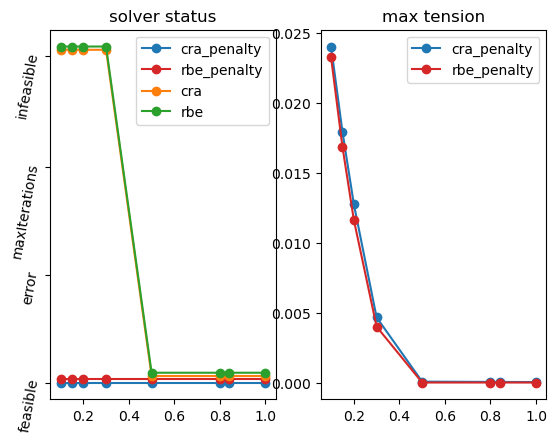

In [11]:
mu = 1.0
density = 0.1
d_bnd = 0.05
# d_bnd = 0.001
eps=0.0001
mus = [0.1, 0.15, 0.2, 0.3, 0.5, 0.8, 0.84, 1.]

solver_options = {
    'max_iter' : 10000,
}
RESULTS[density] = stability_benchmark(assembly, mus=mus, density=density, d_bnd=d_bnd, solver_options=solver_options)



fig, (ax1, ax2)= plt.subplots(ncols=2)

# dual axis plot
ax.set_xlabel("mu")
ax.set_ylabel("max tension")

density = 0.1
plot_result(RESULTS[density], "cra_penalty", ax1, ax2, "C0")
plot_result(RESULTS[density], "rbe_penalty", ax1, ax2, "C3", offset=0.01)
plot_result(RESULTS[density], "cra", ax1, ax2, "C1", offset=0.02)
plot_result(RESULTS[density], "rbe", ax1, ax2, "C2", offset=0.03)


# fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

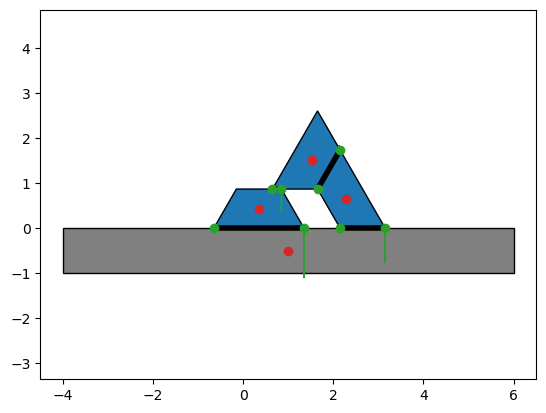

In [12]:
fig, ax = plot_cra_assembly(assembly, force_scale=10, plot_forces=True)

# Bridge Setup
This is creating a stability benchmark using a bridge.

argv[0]=


  0%|          | 0/9 [00:00<?, ?it/s]

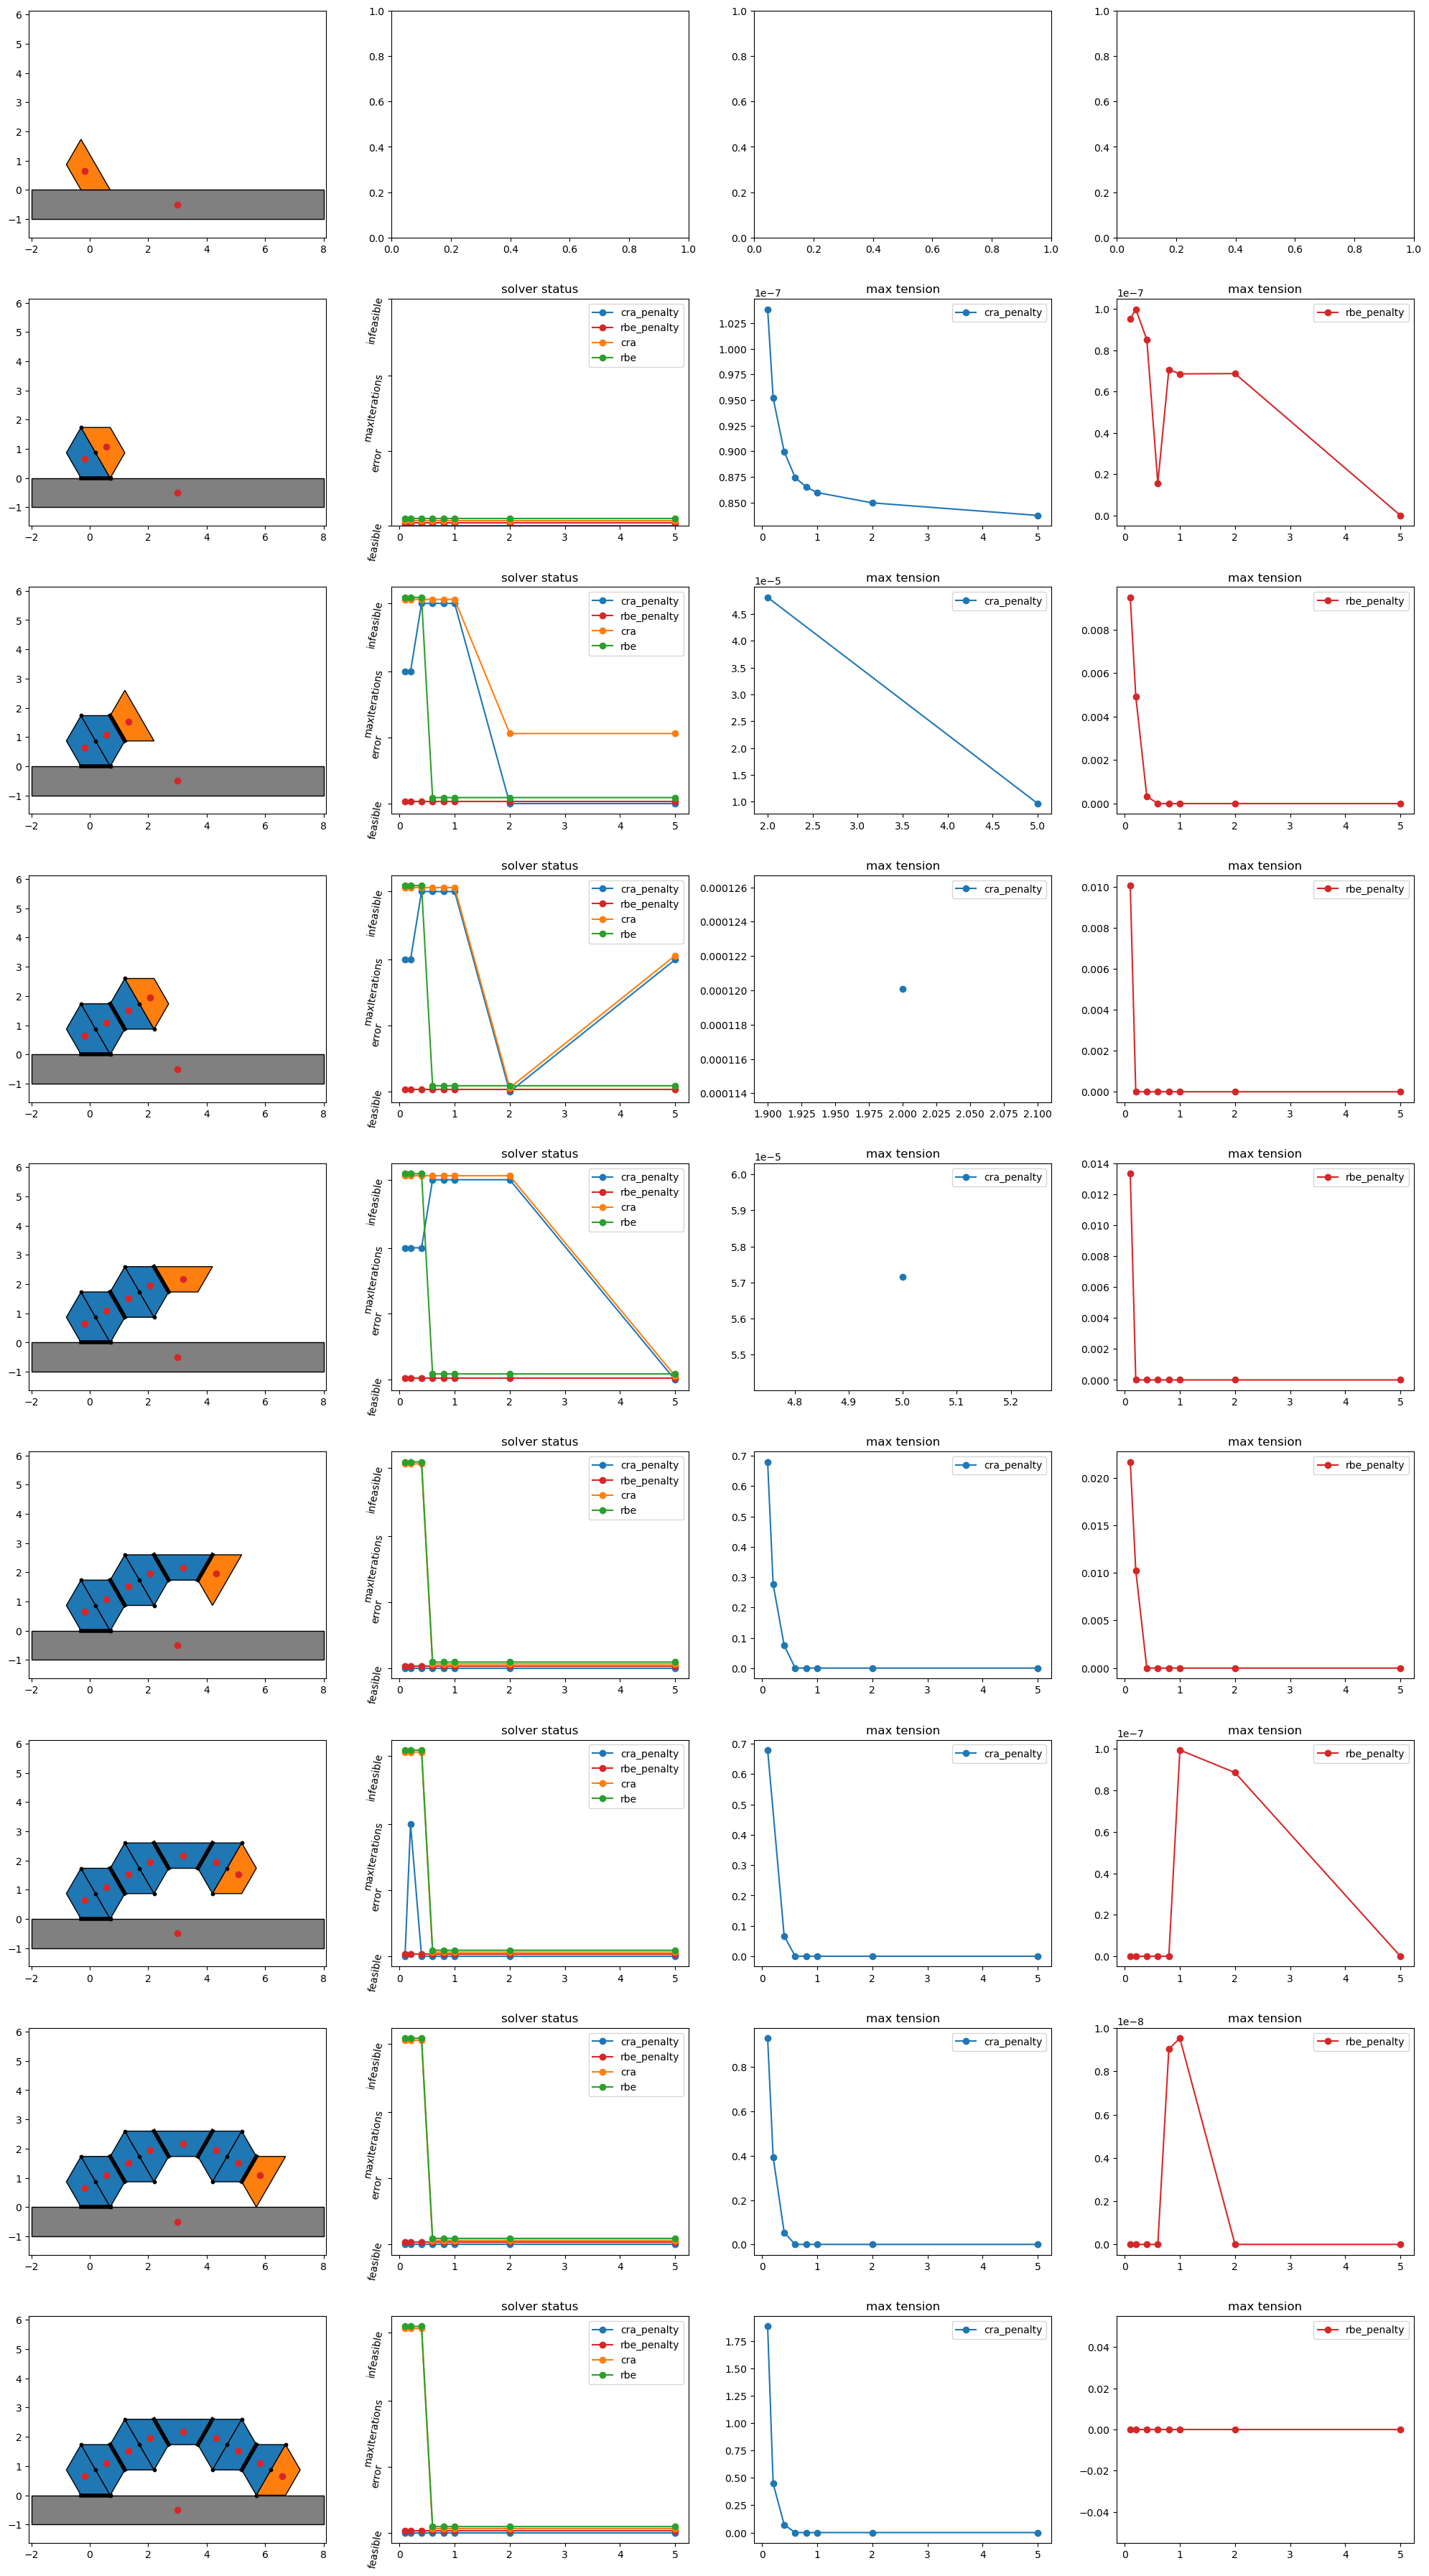

In [74]:
from assembly_gym.envs.assembly_env import AssemblyEnv, Shape, Block
from assembly_gym.envs.gym_env import AssemblyGym, sparse_reward, tower_setup, bridge_setup, hard_tower_setup, Action

from assembly_gym.utils.geometry import align_frames_2d
from assembly_gym.utils.rendering import plot_assembly_env, render_assembly_env, plot_block_movements, plot_cra_assembly

# suppress optimizer warnings
logging.disable(logging.WARNING)
# logging.disable(logging.NOTSET)


mus = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 5.0]
density = 0.1
d_bnd = 0.05
eps=0.0001

solver_options = {
    'max_iter' : 5000,
#     'tol' : 1e-4,
#     'constr_viol_tol' : 1e-4,
#     'compl_inf_tol' : 1e-4,
#     'acceptable_tol' : 1e-4,
#     'acceptable_constr_viol_tol' : 1e-4,
#     'acceptable_compl_inf_tol' : 1e-4,
}
reduced_tol = False
if reduced_tol:
    solver_options.update({
    'tol' : 1e-4,
    'constr_viol_tol' : 1e-4,
    'compl_inf_tol' : 1e-4,
    'acceptable_tol' : 1e-4,
    'acceptable_constr_viol_tol' : 1e-4,
    'acceptable_compl_inf_tol' : 1e-4,
    })

freeze_last_block = True
freeze_first_block = False

env = AssemblyGym(**bridge_setup(num_stories=0, rescale=20), 
                  reward_fct=sparse_reward,
                  restrict_2d=True, 
                  assembly_env=AssemblyEnv(render=False, 
                                           stability_checks=('pybullet', )))
env.reset()

fig, axes = plt.subplots(9, 4, figsize=(5*4, 9*4))

actions = [
    Action(target_block=-1, target_face=0, shape=0, face=0, offset_x=0.2, offset_y=0),
    Action(target_block=0, target_face=3, shape=0, face=3, offset_x=0., offset_y=0),
    Action(target_block=1, target_face=1, shape=0, face=1, offset_x=0, offset_y=0),
    Action(target_block=2, target_face=3, shape=0, face=3, offset_x=0, offset_y=0),
    Action(target_block=3, target_face=1, shape=0, face=2, offset_x=0, offset_y=0),
    Action(target_block=4, target_face=0, shape=0, face=1, offset_x=0, offset_y=0),
    Action(target_block=5, target_face=3, shape=0, face=3, offset_x=0, offset_y=0),
    Action(target_block=6, target_face=1, shape=0, face=1, offset_x=0, offset_y=0),
    Action(target_block=7, target_face=3, shape=0, face=3, offset_x=0, offset_y=0),
]

RESULTS = dict()

for step, (action, axs) in tqdm(enumerate(zip(actions, axes)), total=len(actions), smoothing=1):
    # ax1, ax5, ax2, ax3, ax4 = axs
    # ax1, ax2, ax3, ax4, ax5 = axs
    ax2, ax3, ax4, ax5 = axs
    # ax4 = ax3.twinx()
    obs, reward, terminated, truncated, info = env.step(action)
    # plot_assembly_env(env.assembly_env, fig=fig, ax=ax1)
    # plot_block_movements(info["blocks_initial_state"], info["blocks_final_state"], bounds=None, fig=fig, ax=ax5)

    ax1.set_title(f"Pybullet stable={obs['stable']}")
    # copy setup into CRA environment
    assembly = CRA_Assembly()  # create empty assembly

    

    # create a support block
    thickness=1.
    support = Box(10, 10, thickness, frame=Frame.worldXY().transformed( Translation.from_vector([3., 3., -thickness/2])))
    assembly.add_block(CRA_Block.from_shape(support), node=-1)  # add support to assembly
    assembly.set_boundary_conditions([-1])  # set support as boundary condition

    # add blocks to assembly
    for i, block in enumerate(env.assembly_env.blocks):
        assembly.add_block_from_mesh(block.mesh, node=i)

    # freeze last block
    if freeze_last_block:
        assembly.set_boundary_conditions([i])

    if freeze_first_block:
        assembly.set_boundary_conditions([0])

    # compute interfaces
    assembly_interfaces_numpy(assembly, amin=0.001)  # identify interface between two blocks

    # assembly.to_json(f"../../data/bridge/bridge-{step}-first_frozen={freeze_first_block}-last_frozen={freeze_last_block}.json")
    plot_cra_assembly(assembly, fig=fig, ax=ax2, plot_forces=False, force_scale=100)
    # # continue
    # print(f"Number of edges: {assembly.graph.number_of_edges()}")
    # if step == 1:
    #     rbe_solve(assembly, mu=2, penalty=False, density=0.1, verbose=False, timer=False, solver_options=solver_options)
    #     # rbe_solve(assembly, mu=0.95, penalty=True, density=0.1, verbose=False, timer=False, solver_options=solver_options)
    #     # cra_penalty_solve(assembly, mu=0.8, density=density, d_bnd=d_bnd, eps=eps, verbose=False, timer=False, solver_options=solver_options)
    #     print(f"Maximum tension: {maximum_tension(assembly)}")
    #     # plot CRA assembly
    #     plot_cra_assembly(assembly, fig=fig, ax=ax2, plot_forces=True, force_scale=100)
    # if step == 1:
    #     break
    # continue
    # break


    # for ax in [ax1, ax2]:
    for ax in [ax2]:
        ax.set_xlim(-2, 8)
        ax.set_ylim(-0.5, 5)

    if step == 0:
        continue
    if step == 1 and freeze_first_block:
        continue
    # if step > 2:
    #     continue
    # if step not in [1, 2,]:
    #     continue
    
    results = stability_benchmark(assembly,mus=mus, density=density, d_bnd=d_bnd, eps=eps, solver_options=solver_options)
    RESULTS[step] = results

    plot_result(results, "cra_penalty", ax3, ax4, "C0")
    plot_result(results, "rbe_penalty", ax3, ax5, "C3", offset=0.01)
    plot_result(results, "cra", ax3, ax4, "C1", offset=0.02)
    plot_result(results, "rbe", ax3, ax4, "C2", offset=0.03)

    ax3.legend()
    ax3.legend()


fig.tight_layout()
fig.subplots_adjust()

plt.savefig(f"../../plots/bridge_stability-density={density}-d_bnd={d_bnd}-eps={eps}-last_frozen={freeze_last_block}-first_frozen={freeze_first_block}-reduced_tol={reduced_tol}.pdf")


6


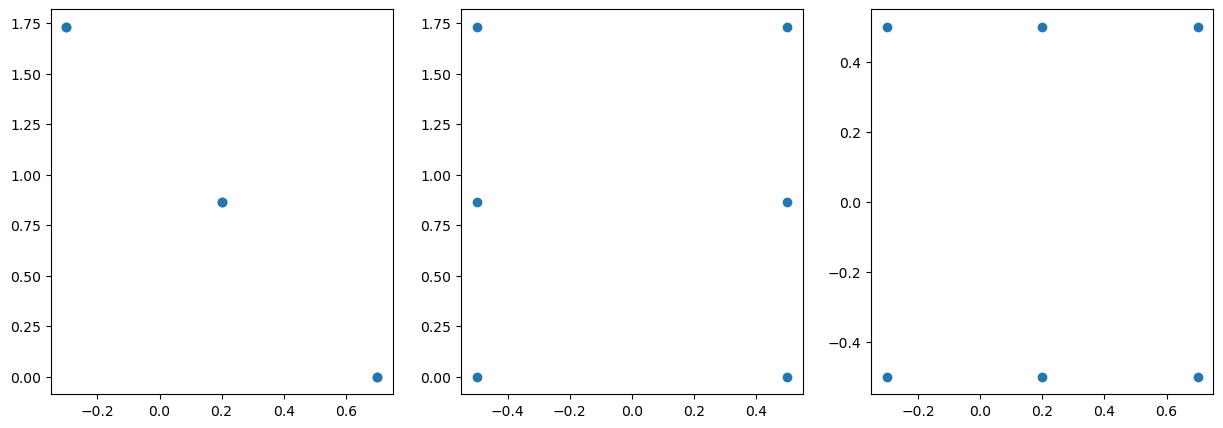

In [53]:
m = block.mesh
inter = [*assembly.interfaces()][0]
points = np.array(inter.points)
print(len(points))

# plot 2d projections along each axis
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(points[:, 0], points[:, 2], 'o')
ax2.plot(points[:, 1], points[:, 2], 'o')
ax3.plot(points[:, 0], points[:, 1], 'o')

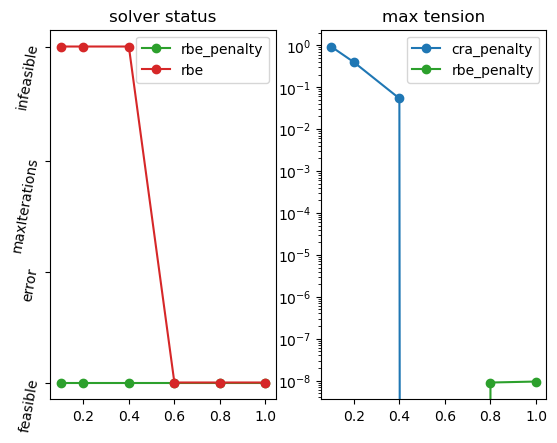

In [41]:
# plot results for a single step
fig, (ax1, ax2) = plt.subplots(ncols=2)

results = RESULTS[7]

plot_result(results, "cra_penalty", ax, ax2, "C0")
plot_result(results, "cra", ax, ax2, "C1")
plot_result(results, "rbe_penalty", ax1, ax2, "C2")
plot_result(results, "rbe", ax1, ax2, "C3")

argv[0]=


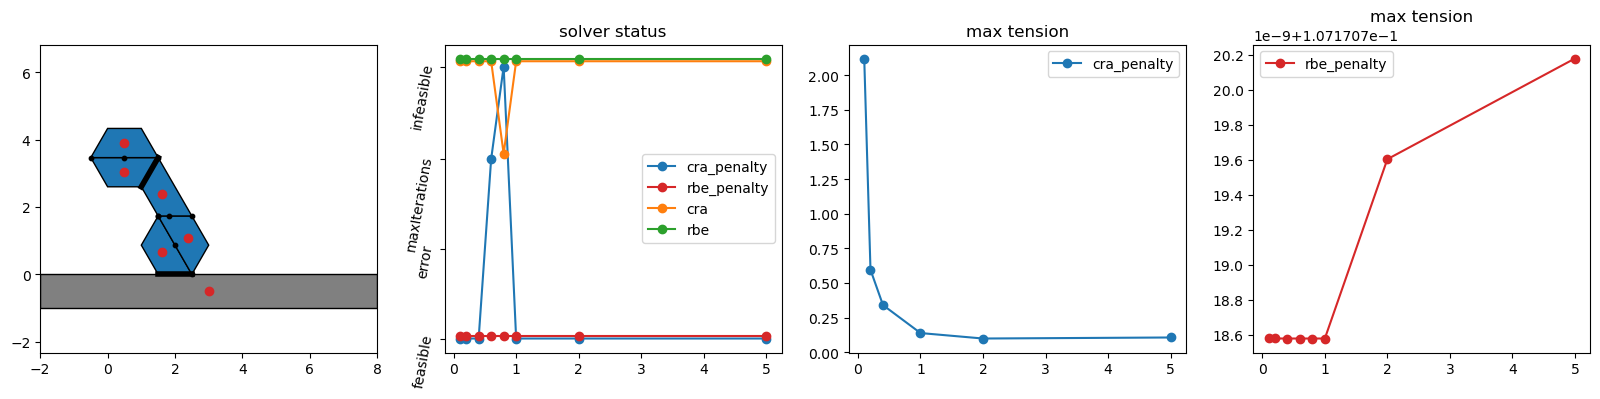

In [96]:
from assembly_gym.envs.assembly_env import AssemblyEnv, Shape, Block
from assembly_gym.envs.gym_env import AssemblyGym, sparse_reward, tower_setup, bridge_setup, hard_tower_setup, Action

from assembly_gym.utils.geometry import align_frames_2d
from assembly_gym.utils.rendering import plot_assembly_env, render_assembly_env, plot_block_movements, plot_cra_assembly

# suppress optimizer warnings
logging.disable(logging.WARNING)
# logging.disable(logging.NOTSET)


mus = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 5.0]
density = 0.1
d_bnd = 0.05
eps=0.0001

solver_options = {
    'max_iter' : 5000,
#     'tol' : 1e-4,
#     'constr_viol_tol' : 1e-4,
#     'compl_inf_tol' : 1e-4,
#     'acceptable_tol' : 1e-4,
#     'acceptable_constr_viol_tol' : 1e-4,
#     'acceptable_compl_inf_tol' : 1e-4,
}
reduced_tol = False
if reduced_tol:
    solver_options.update({
    'tol' : 1e-4,
    'constr_viol_tol' : 1e-4,
    'compl_inf_tol' : 1e-4,
    'acceptable_tol' : 1e-4,
    'acceptable_constr_viol_tol' : 1e-4,
    'acceptable_compl_inf_tol' : 1e-4,
    })

freeze_last_block = False
freeze_first_block = False

env = AssemblyGym(**bridge_setup(num_stories=0, rescale=20), 
                  reward_fct=sparse_reward,
                  restrict_2d=True, 
                  assembly_env=AssemblyEnv(render=False, 
                                           stability_checks=('pybullet', )))
env.reset()

fig, axes = plt.subplots(1, 4, figsize=(5*4, 1*4), squeeze=False)

actions = [
    Action(target_block=-1, target_face=0, shape=0, face=0, offset_x=2, offset_y=0),
    Action(target_block=0, target_face=3, shape=0, face=3, offset_x=0., offset_y=0),
    Action(target_block=1, target_face=0, shape=0, face=0, offset_x=0, offset_y=0),
    Action(target_block=2, target_face=2, shape=0, face=0, offset_x=0, offset_y=0),
    Action(target_block=3, target_face=3, shape=0, face=3, offset_x=0, offset_y=0),
    # Action(target_block=4, target_face=0, shape=0, face=1, offset_x=0, offset_y=0),
    # Action(target_block=5, target_face=3, shape=0, face=3, offset_x=0, offset_y=0),
    # Action(target_block=6, target_face=1, shape=0, face=1, offset_x=0, offset_y=0),
    # Action(target_block=7, target_face=3, shape=0, face=3, offset_x=0, offset_y=0),
]

RESULTS = dict()

for step, action in enumerate(actions):
    # ax1, ax5, ax2, ax3, ax4 = axs
    # ax1, ax2, ax3, ax4, ax5 = axs
    # ax4 = ax3.twinx()
    obs, reward, terminated, truncated, info = env.step(action)
    # plot_assembly_env(env.assembly_env, fig=fig, ax=ax1)
    # plot_block_movements(info["blocks_initial_state"], info["blocks_final_state"], bounds=None, fig=fig, ax=ax5)

ax2, ax3, ax4, ax5 = axes[0]
ax1.set_title(f"Pybullet stable={obs['stable']}")
# copy setup into CRA environment
assembly = CRA_Assembly()  # create empty assembly


# create a support block
thickness=1.
support = Box(10, 10, thickness, frame=Frame.worldXY().transformed( Translation.from_vector([3., 3., -thickness/2])))
assembly.add_block(CRA_Block.from_shape(support), node=-1)  # add support to assembly
assembly.set_boundary_conditions([-1])  # set support as boundary condition

# add blocks to assembly
for i, block in enumerate(env.assembly_env.blocks):
    assembly.add_block_from_mesh(block.mesh, node=i)

# freeze last block
if freeze_last_block:
    assembly.set_boundary_conditions([i])

if freeze_first_block:
    assembly.set_boundary_conditions([0])

# compute interfaces
assembly_interfaces_numpy(assembly, amin=0.001)  # identify interface between two blocks

# assembly.to_json(f"../../data/bridge/bridge-{step}-first_frozen={freeze_first_block}-last_frozen={freeze_last_block}.json")
plot_cra_assembly(assembly, fig=fig, ax=ax2, plot_forces=False, force_scale=100)
# # continue
# print(f"Number of edges: {assembly.graph.number_of_edges()}")
# if step == 1:
#     rbe_solve(assembly, mu=2, penalty=False, density=0.1, verbose=False, timer=False, solver_options=solver_options)
#     # rbe_solve(assembly, mu=0.95, penalty=True, density=0.1, verbose=False, timer=False, solver_options=solver_options)
#     # cra_penalty_solve(assembly, mu=0.8, density=density, d_bnd=d_bnd, eps=eps, verbose=False, timer=False, solver_options=solver_options)
#     print(f"Maximum tension: {maximum_tension(assembly)}")
#     # plot CRA assembly
#     plot_cra_assembly(assembly, fig=fig, ax=ax2, plot_forces=True, force_scale=100)
# if step == 1:
#     break
# continue
# break


# for ax in [ax1, ax2]:
for ax in [ax2]:
    ax.set_xlim(-2, 8)
    ax.set_ylim(-0.5, 5)

# if step > 2:
#     continue
# if step not in [1, 2,]:
#     continue

results = stability_benchmark(assembly,mus=mus, density=density, d_bnd=d_bnd, eps=eps, solver_options=solver_options)
# RESULTS[step] = results

plot_result(results, "cra_penalty", ax3, ax4, "C0")
plot_result(results, "rbe_penalty", ax3, ax5, "C3", offset=0.01)
plot_result(results, "cra", ax3, ax4, "C1", offset=0.02)
plot_result(results, "rbe", ax3, ax4, "C2", offset=0.03)

ax3.legend()
ax3.legend()


# fig.tight_layout()
# fig.subplots_adjust()

# plt.savefig(f"../../plots/bridge_stability-density={density}-d_bnd={d_bnd}-eps={eps}-last_frozen={freeze_last_block}-first_frozen={freeze_first_block}-reduced_tol={reduced_tol}.pdf")


argv[0]=


  0%|          | 0/5 [00:00<?, ?it/s]

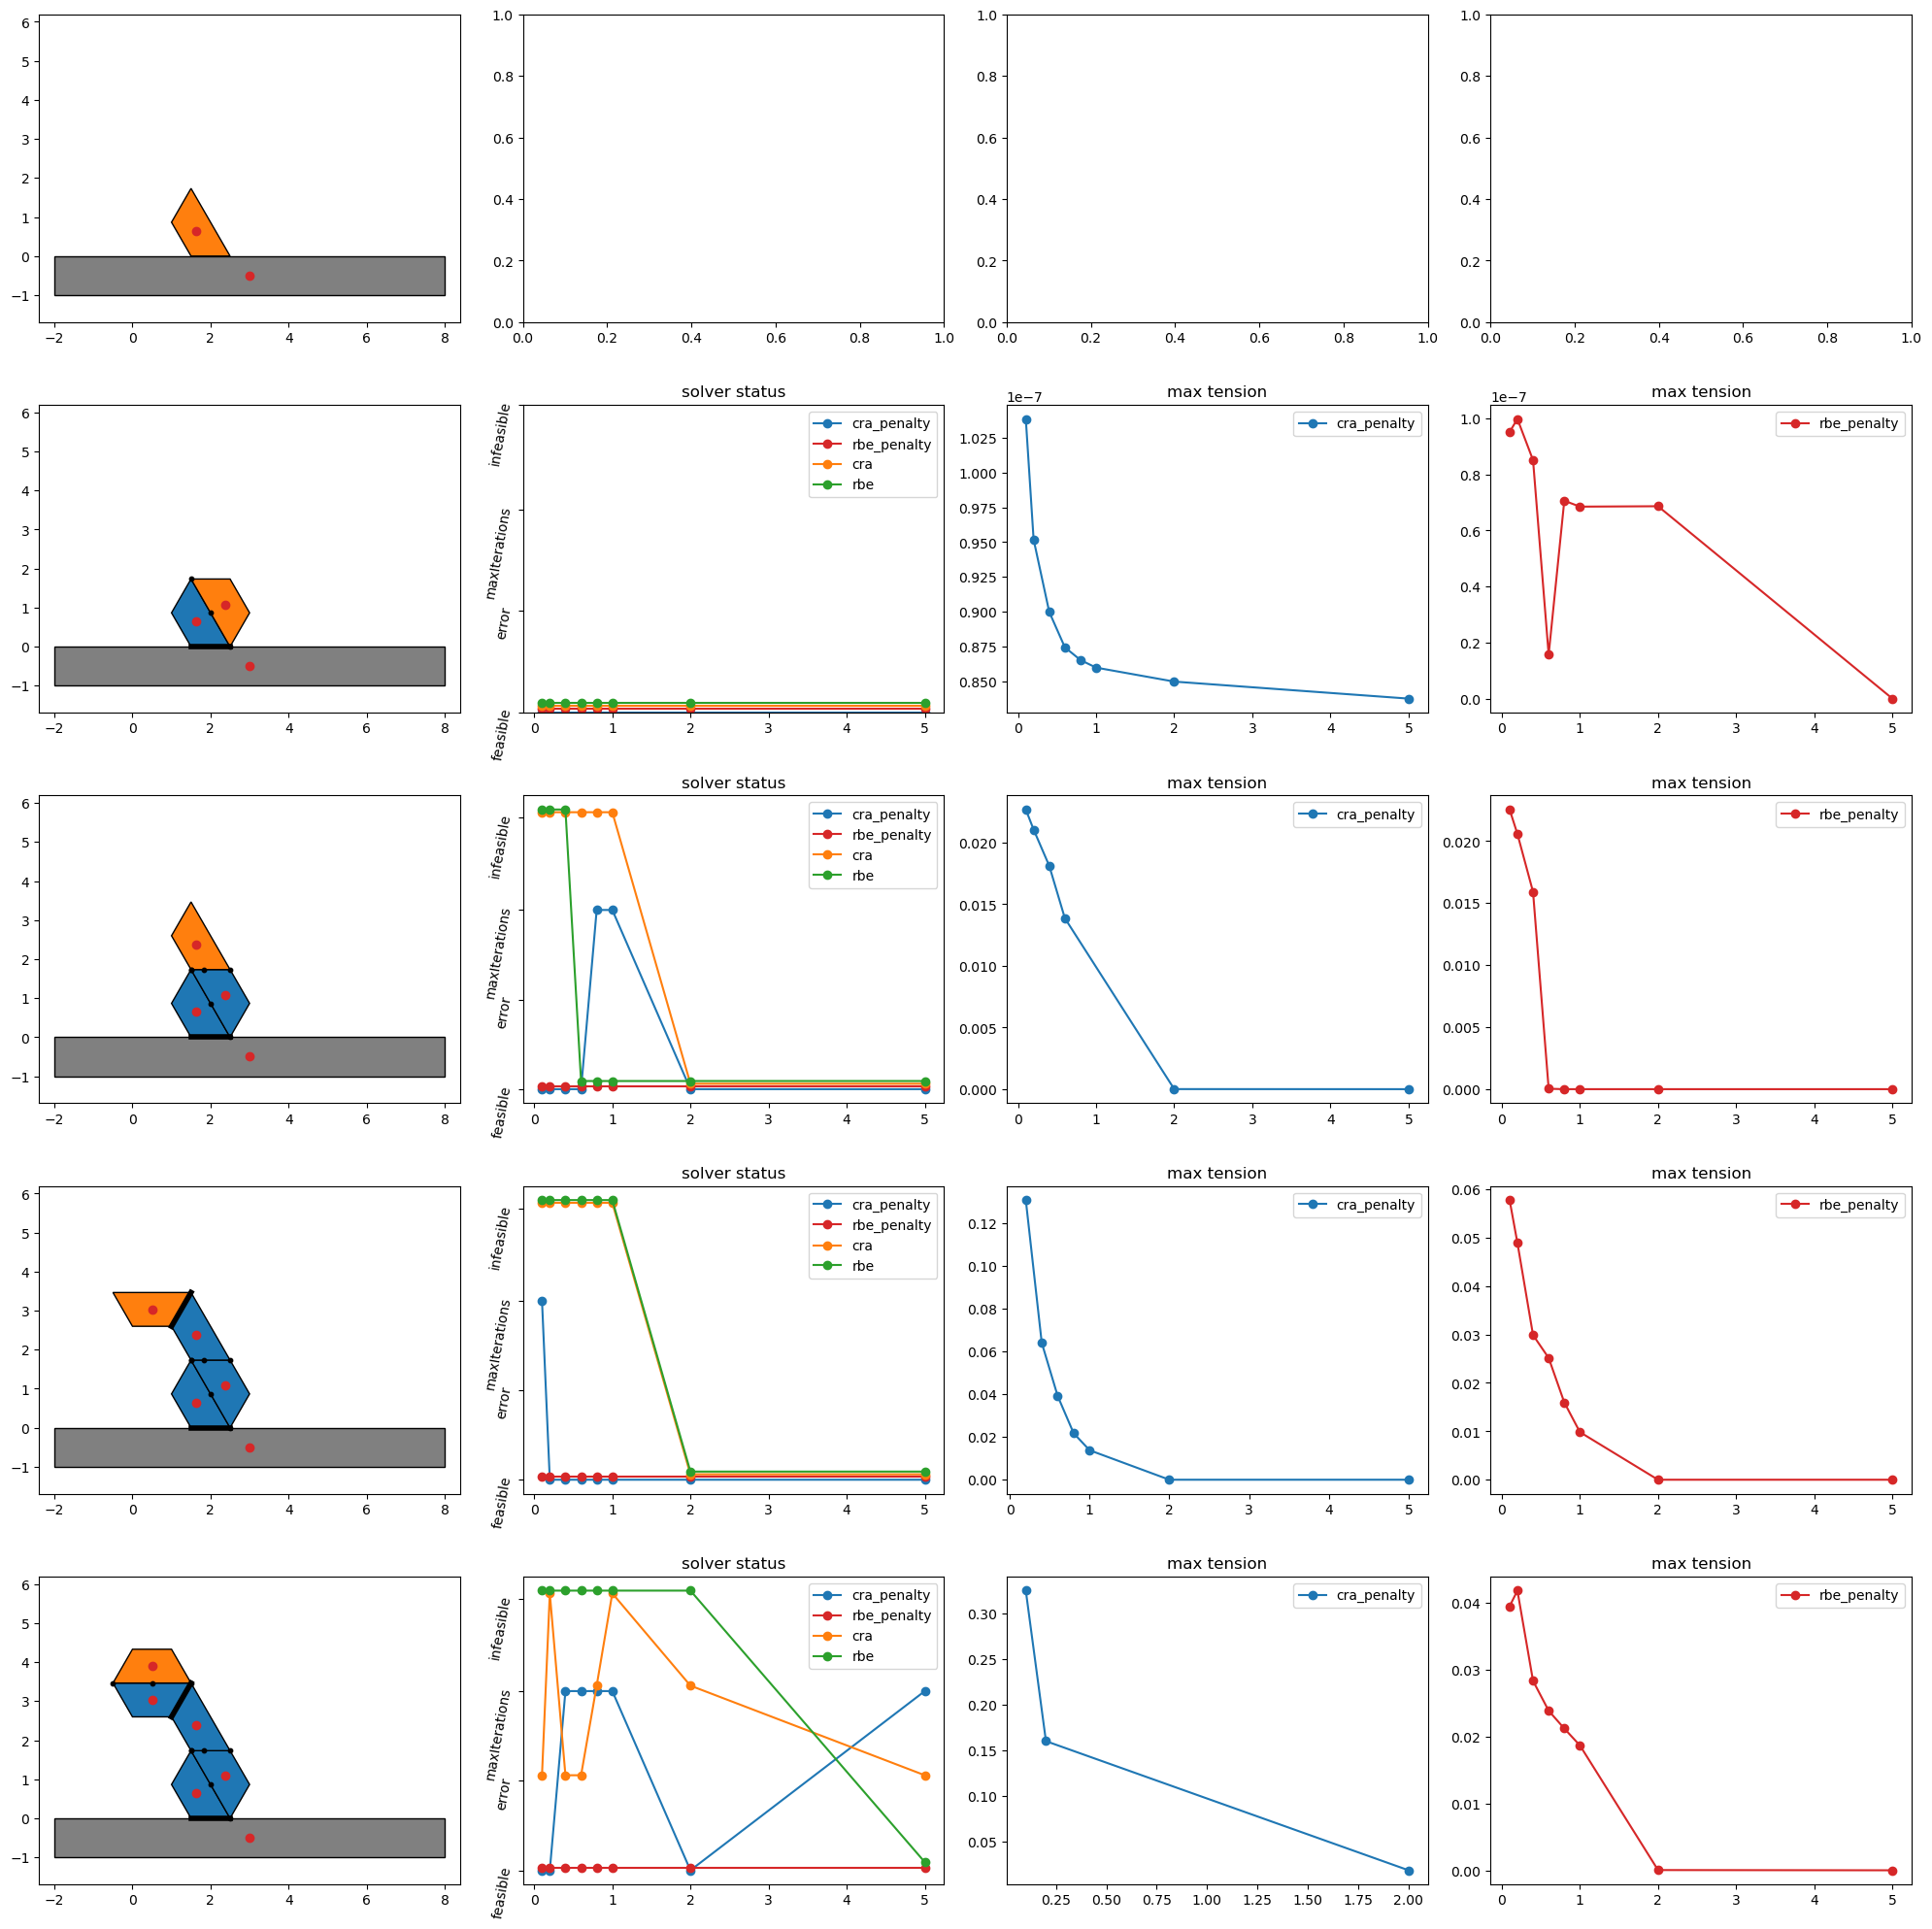

In [99]:
from assembly_gym.envs.assembly_env import AssemblyEnv, Shape, Block
from assembly_gym.envs.gym_env import AssemblyGym, sparse_reward, tower_setup, bridge_setup, hard_tower_setup, Action

from assembly_gym.utils.geometry import align_frames_2d
from assembly_gym.utils.rendering import plot_assembly_env, render_assembly_env, plot_block_movements, plot_cra_assembly

# suppress optimizer warnings
logging.disable(logging.WARNING)
# logging.disable(logging.NOTSET)


mus = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 5.0]
density = 0.1
d_bnd = 0.05
eps=0.0001

solver_options = {
    'max_iter' : 5000,
#     'tol' : 1e-4,
#     'constr_viol_tol' : 1e-4,
#     'compl_inf_tol' : 1e-4,
#     'acceptable_tol' : 1e-4,
#     'acceptable_constr_viol_tol' : 1e-4,
#     'acceptable_compl_inf_tol' : 1e-4,
}
reduced_tol = False
if reduced_tol:
    solver_options.update({
    'tol' : 1e-4,
    'constr_viol_tol' : 1e-4,
    'compl_inf_tol' : 1e-4,
    'acceptable_tol' : 1e-4,
    'acceptable_constr_viol_tol' : 1e-4,
    'acceptable_compl_inf_tol' : 1e-4,
    })

freeze_last_block = True
freeze_first_block = False

env = AssemblyGym(**bridge_setup(num_stories=0, rescale=20), 
                  reward_fct=sparse_reward,
                  restrict_2d=True, 
                  assembly_env=AssemblyEnv(render=False, 
                                           stability_checks=('pybullet', )))
env.reset()

fig, axes = plt.subplots(5, 4, figsize=(5*4, 5*4))

actions = [
    Action(target_block=-1, target_face=0, shape=0, face=0, offset_x=2, offset_y=0),
    Action(target_block=0, target_face=3, shape=0, face=3, offset_x=0., offset_y=0),
    Action(target_block=1, target_face=0, shape=0, face=0, offset_x=0, offset_y=0),
    Action(target_block=2, target_face=2, shape=0, face=0, offset_x=0, offset_y=0),
    Action(target_block=3, target_face=3, shape=0, face=3, offset_x=0, offset_y=0),
    # Action(target_block=4, target_face=0, shape=0, face=1, offset_x=0, offset_y=0),
    # Action(target_block=5, target_face=3, shape=0, face=3, offset_x=0, offset_y=0),
    # Action(target_block=6, target_face=1, shape=0, face=1, offset_x=0, offset_y=0),
    # Action(target_block=7, target_face=3, shape=0, face=3, offset_x=0, offset_y=0),
]

RESULTS = dict()

for step, (action, axs) in tqdm(enumerate(zip(actions, axes)), total=len(actions), smoothing=1):
    # ax1, ax5, ax2, ax3, ax4 = axs
    # ax1, ax2, ax3, ax4, ax5 = axs
    ax2, ax3, ax4, ax5 = axs
    # ax4 = ax3.twinx()
    obs, reward, terminated, truncated, info = env.step(action)
    # plot_assembly_env(env.assembly_env, fig=fig, ax=ax1)
    # plot_block_movements(info["blocks_initial_state"], info["blocks_final_state"], bounds=None, fig=fig, ax=ax5)

    ax1.set_title(f"Pybullet stable={obs['stable']}")
    # copy setup into CRA environment
    assembly = CRA_Assembly()  # create empty assembly

    

    # create a support block
    thickness=1.
    support = Box(10, 10, thickness, frame=Frame.worldXY().transformed( Translation.from_vector([3., 3., -thickness/2])))
    assembly.add_block(CRA_Block.from_shape(support), node=-1)  # add support to assembly
    assembly.set_boundary_conditions([-1])  # set support as boundary condition

    # add blocks to assembly
    for i, block in enumerate(env.assembly_env.blocks):
        assembly.add_block_from_mesh(block.mesh, node=i)

    # freeze last block
    if freeze_last_block:
        assembly.set_boundary_conditions([i])

    if freeze_first_block:
        assembly.set_boundary_conditions([0])

    # compute interfaces
    assembly_interfaces_numpy(assembly, amin=0.001)  # identify interface between two blocks

    # assembly.to_json(f"../../data/bridge/bridge-{step}-first_frozen={freeze_first_block}-last_frozen={freeze_last_block}.json")
    plot_cra_assembly(assembly, fig=fig, ax=ax2, plot_forces=False, force_scale=100)
    # # continue
    # print(f"Number of edges: {assembly.graph.number_of_edges()}")
    # if step == 1:
    #     rbe_solve(assembly, mu=2, penalty=False, density=0.1, verbose=False, timer=False, solver_options=solver_options)
    #     # rbe_solve(assembly, mu=0.95, penalty=True, density=0.1, verbose=False, timer=False, solver_options=solver_options)
    #     # cra_penalty_solve(assembly, mu=0.8, density=density, d_bnd=d_bnd, eps=eps, verbose=False, timer=False, solver_options=solver_options)
    #     print(f"Maximum tension: {maximum_tension(assembly)}")
    #     # plot CRA assembly
    #     plot_cra_assembly(assembly, fig=fig, ax=ax2, plot_forces=True, force_scale=100)
    # if step == 1:
    #     break
    # continue
    # break


    # for ax in [ax1, ax2]:
    for ax in [ax2]:
        ax.set_xlim(-2, 8)
        ax.set_ylim(-0.5, 5)

    if step == 0:
        continue
    if step == 1 and freeze_first_block:
        continue
    # if step > 2:
    #     continue
    # if step not in [1, 2,]:
    #     continue
    
    results = stability_benchmark(assembly,mus=mus, density=density, d_bnd=d_bnd, eps=eps, solver_options=solver_options)
    RESULTS[step] = results

    plot_result(results, "cra_penalty", ax3, ax4, "C0")
    plot_result(results, "rbe_penalty", ax3, ax5, "C3", offset=0.01)
    plot_result(results, "cra", ax3, ax4, "C1", offset=0.02)
    plot_result(results, "rbe", ax3, ax4, "C2", offset=0.03)

    ax3.legend()
    ax3.legend()


fig.tight_layout()
fig.subplots_adjust()

plt.savefig(f"../../plots/leaning-density={density}-d_bnd={d_bnd}-eps={eps}-last_frozen={freeze_last_block}-first_frozen={freeze_first_block}-reduced_tol={reduced_tol}.pdf")


(<Figure size 640x480 with 1 Axes>, <Axes: >)

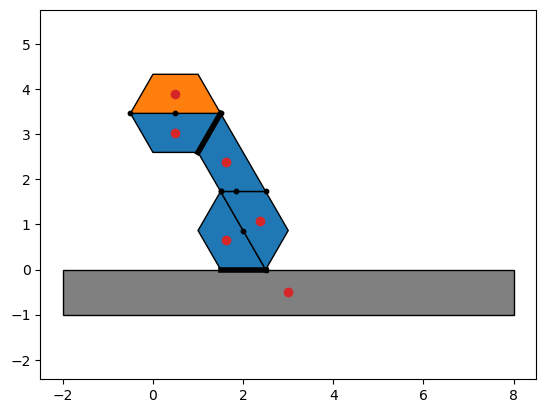

In [100]:
plot_cra_assembly(assembly, force_scale=10, plot_forces=False)

In [101]:
assembly.to_json('test.json')

(<Figure size 640x480 with 1 Axes>, <Axes: >)

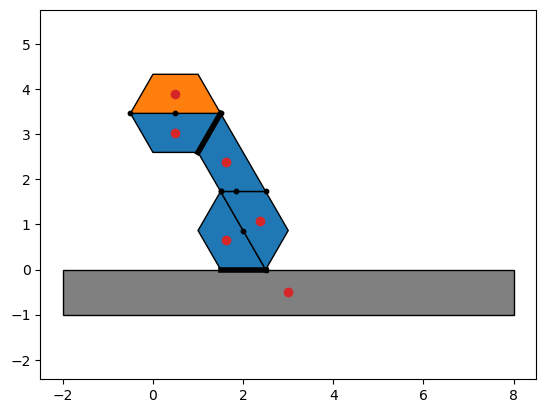

In [103]:
# loading 
assembly2 = CRA_Assembly()
assembly2 = CRA_Assembly.from_json('test.json')
plot_cra_assembly(assembly2, force_scale=10, plot_forces=False)

argv[0]=


  0%|          | 0/1 [00:00<?, ?it/s]

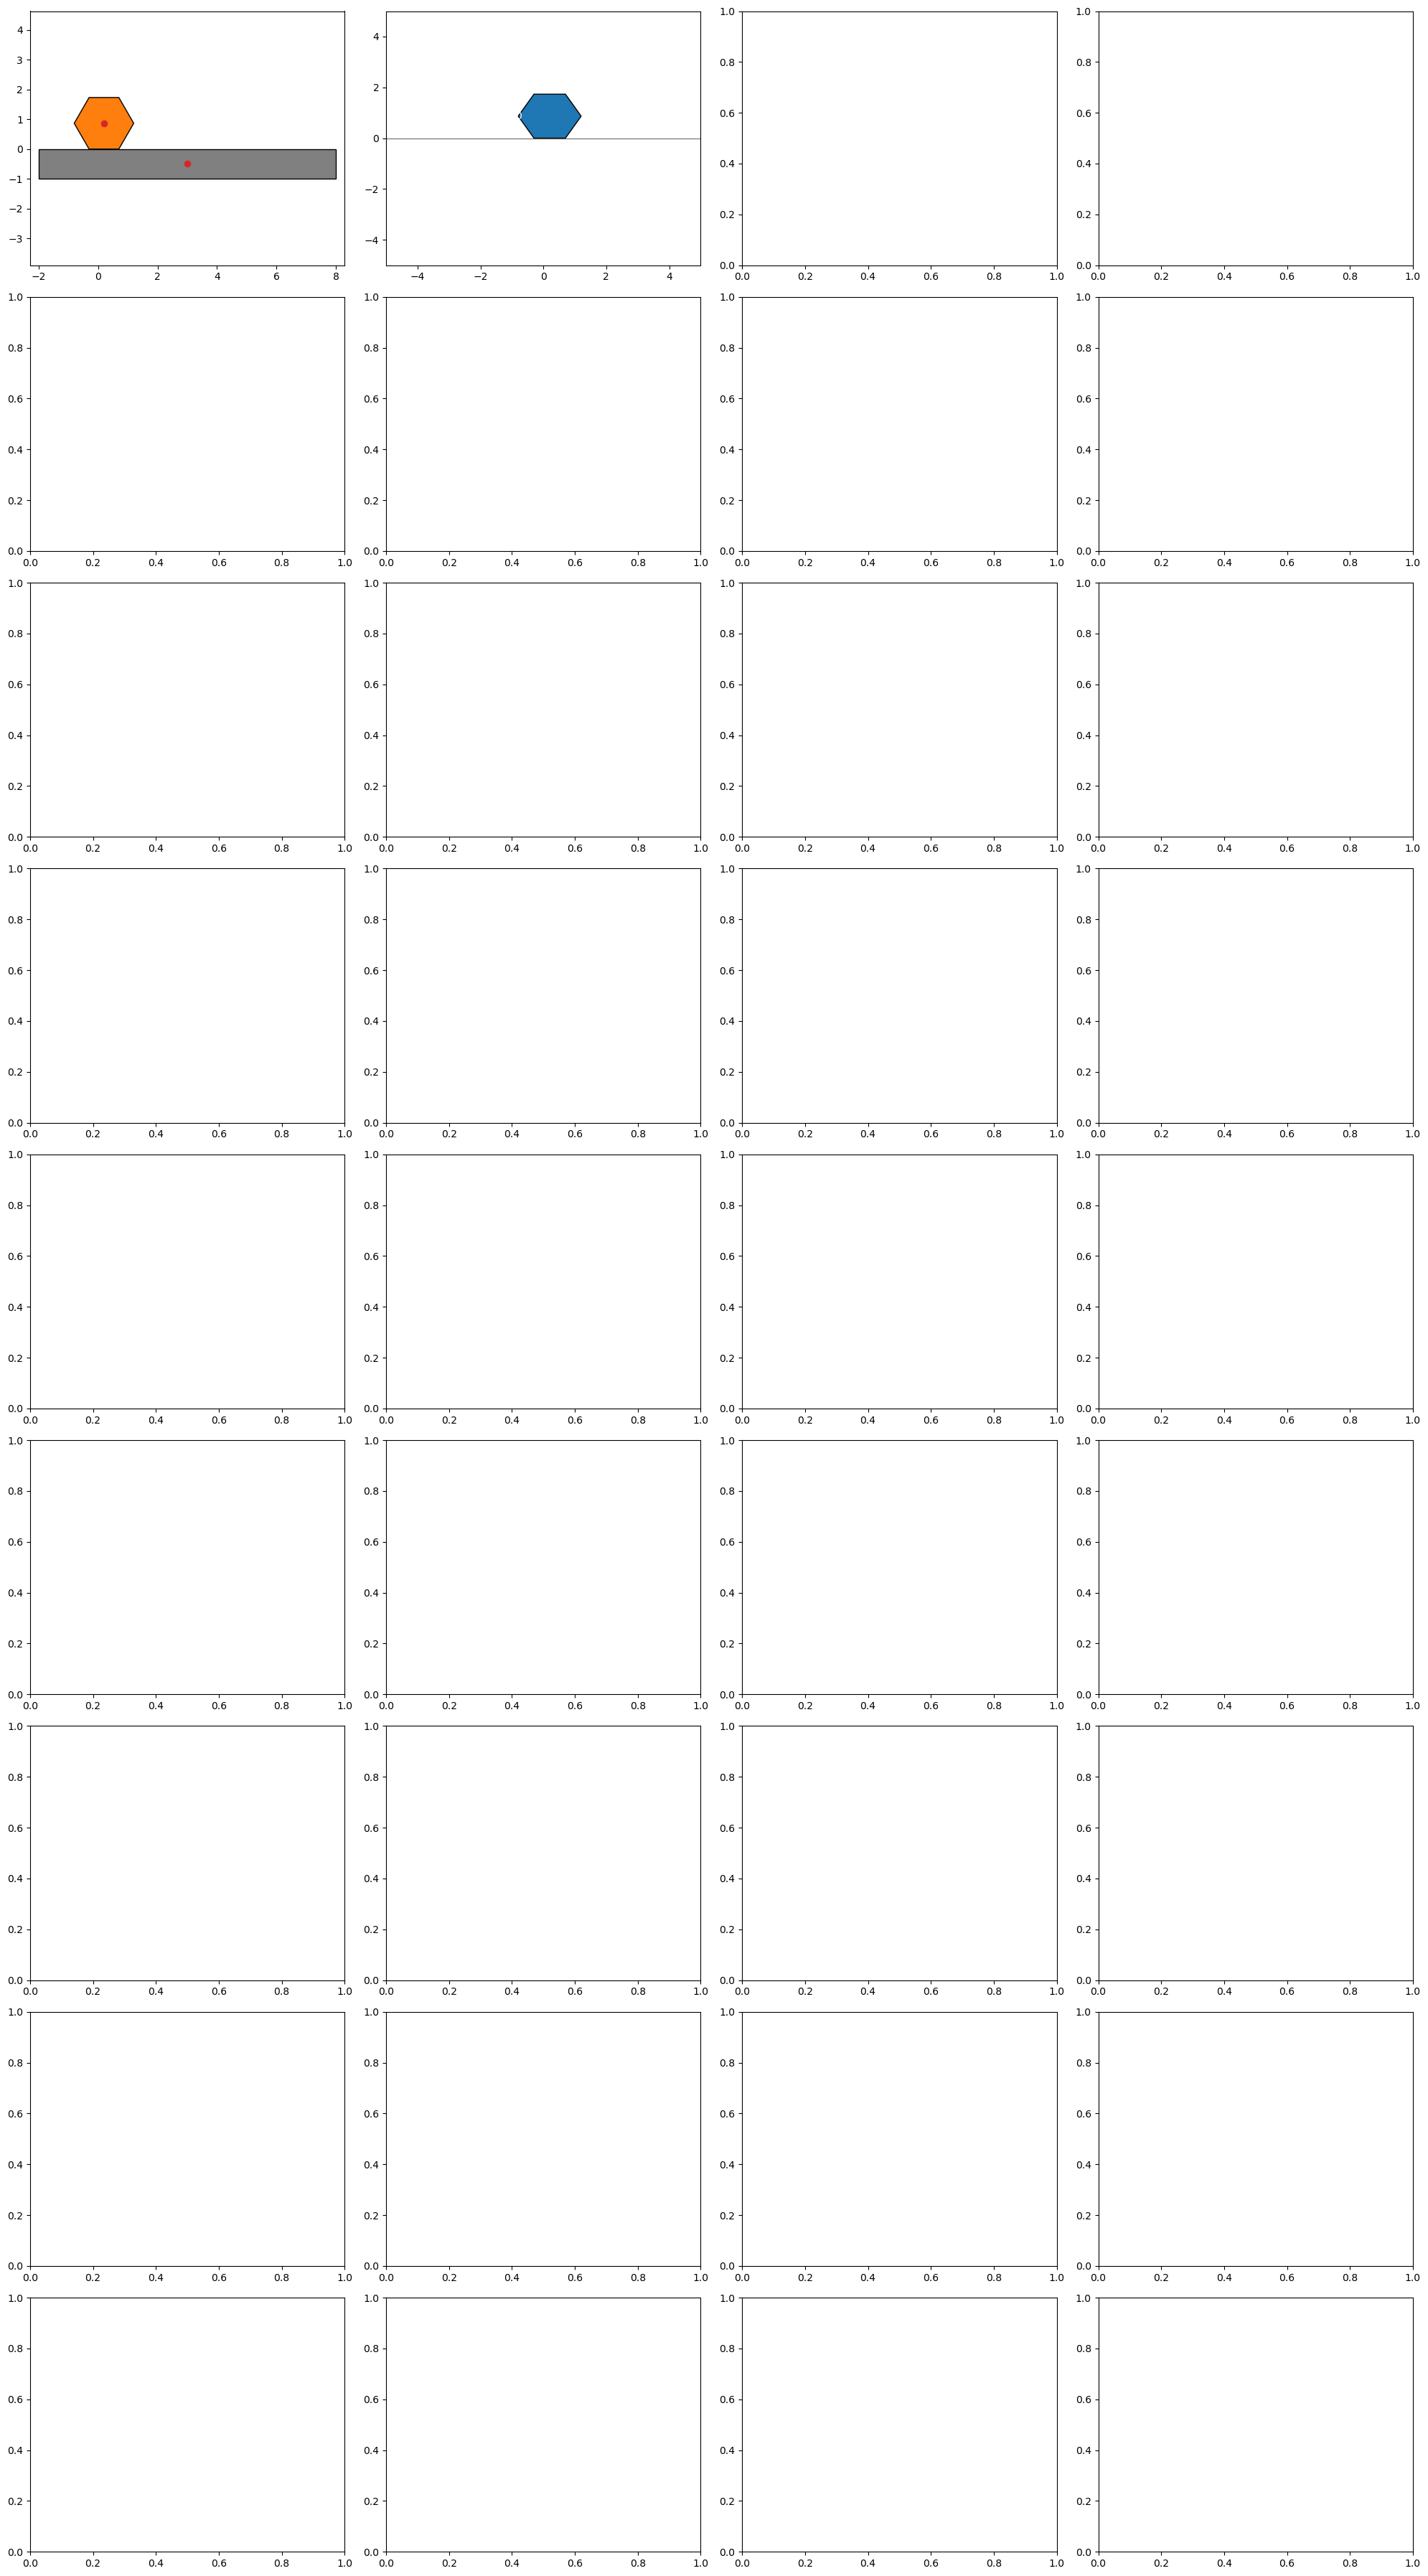

In [103]:
from assembly_gym.envs.assembly_env import AssemblyEnv, Shape, Block
from assembly_gym.envs.gym_env import AssemblyGym, sparse_reward, tower_setup, bridge_setup, hard_tower_setup, Action

from assembly_gym.utils.geometry import align_frames_2d
from assembly_gym.utils.rendering import plot_assembly_env, render_assembly_env, plot_block_movements, plot_cra_assembly

# suppress optimizer warnings
logging.disable(logging.WARNING)
# logging.disable(logging.NOTSET)


mus = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 5.0]
density = 0.1
d_bnd = 0.05
eps=0.0001

solver_options = {
    'max_iter' : 5000,
#     'tol' : 1e-4,
#     'constr_viol_tol' : 1e-4,
#     'compl_inf_tol' : 1e-4,
#     'acceptable_tol' : 1e-4,
#     'acceptable_constr_viol_tol' : 1e-4,
#     'acceptable_compl_inf_tol' : 1e-4,
}
reduced_tol = False
if reduced_tol:
    solver_options.update({
    'tol' : 1e-4,
    'constr_viol_tol' : 1e-4,
    'compl_inf_tol' : 1e-4,
    'acceptable_tol' : 1e-4,
    'acceptable_constr_viol_tol' : 1e-4,
    'acceptable_compl_inf_tol' : 1e-4,
    })

freeze_last_block = True
freeze_first_block = False

env = AssemblyGym(**bridge_setup(num_stories=0, hexagon=True, trapezoid=False), 
                  reward_fct=sparse_reward,
                  restrict_2d=True, 
                  assembly_env=AssemblyEnv(render=False, 
                                           stability_checks=('pybullet', ),
                                            bounds=np.array([[-5., -1., -5], [5., 10., 5.]])))
env.reset()

fig, axes = plt.subplots(9, 4, figsize=(5*4, 9*4))

actions = [
    Action(target_block=-1, target_face=0, shape=0, face=0, offset_x=0.2, offset_y=0),
#     Action(target_block=0, target_face=3, shape=0, face=3, offset_x=0., offset_y=0),
#     Action(target_block=1, target_face=1, shape=0, face=1, offset_x=0, offset_y=0),
#     Action(target_block=2, target_face=3, shape=0, face=3, offset_x=0, offset_y=0),
#     Action(target_block=3, target_face=1, shape=0, face=2, offset_x=0, offset_y=0),
#     Action(target_block=4, target_face=0, shape=0, face=1, offset_x=0, offset_y=0),
#     Action(target_block=5, target_face=3, shape=0, face=3, offset_x=0, offset_y=0),
#     Action(target_block=6, target_face=1, shape=0, face=1, offset_x=0, offset_y=0),
#     Action(target_block=7, target_face=3, shape=0, face=3, offset_x=0, offset_y=0),
]

RESULTS = dict()

for step, (action, axs) in tqdm(enumerate(zip(actions, axes)), total=len(actions), smoothing=1):
    # ax1, ax5, ax2, ax3, ax4 = axs
    # ax1, ax2, ax3, ax4, ax5 = axs
    ax2, ax1, ax4, ax5 = axs
    # ax4 = ax3.twinx()
    obs, reward, terminated, truncated, info = env.step(action)
    plot_assembly_env(env.assembly_env, fig=fig, ax=ax1)
    # plot_block_movements(info["blocks_initial_state"], info["blocks_final_state"], bounds=None, fig=fig, ax=ax5)

    # ax1.set_title(f"Pybullet stable={obs['stable']}")
    # copy setup into CRA environment
    assembly = CRA_Assembly()  # create empty assembly

    

    # create a support block
    thickness=1.
    support = Box(10, 10, thickness, frame=Frame.worldXY().transformed( Translation.from_vector([3., 3., -thickness/2])))
    assembly.add_block(CRA_Block.from_shape(support), node=-1)  # add support to assembly
    assembly.set_boundary_conditions([-1])  # set support as boundary condition

    # add blocks to assembly
    for i, block in enumerate(env.assembly_env.blocks):
        assembly.add_block_from_mesh(block.mesh, node=i)

    # freeze last block
    if freeze_last_block:
        assembly.set_boundary_conditions([i])

    if freeze_first_block:
        assembly.set_boundary_conditions([0])

    # compute interfaces
    assembly_interfaces_numpy(assembly, amin=0.001)  # identify interface between two blocks

    # assembly.to_json(f"../../data/bridge/bridge-{step}-first_frozen={freeze_first_block}-last_frozen={freeze_last_block}.json")
    plot_cra_assembly(assembly, fig=fig, ax=ax2, plot_forces=False, force_scale=100)
    continue
    # print(f"Number of edges: {assembly.graph.number_of_edges()}")
    # if step == 1:
    #     rbe_solve(assembly, mu=2, penalty=False, density=0.1, verbose=False, timer=False, solver_options=solver_options)
    #     # rbe_solve(assembly, mu=0.95, penalty=True, density=0.1, verbose=False, timer=False, solver_options=solver_options)
    #     # cra_penalty_solve(assembly, mu=0.8, density=density, d_bnd=d_bnd, eps=eps, verbose=False, timer=False, solver_options=solver_options)
    #     print(f"Maximum tension: {maximum_tension(assembly)}")
    #     # plot CRA assembly
    #     plot_cra_assembly(assembly, fig=fig, ax=ax2, plot_forces=True, force_scale=100)
    # if step == 1:
    #     break
    # continue
    # break


    # for ax in [ax1, ax2]:
    for ax in [ax2]:
        ax.set_xlim(-2, 8)
        ax.set_ylim(-0.5, 5)

    if step == 0:
        continue
    if step == 1 and freeze_first_block:
        continue
    # if step > 2:
    #     continue
    # if step not in [1, 2,]:
    #     continue
    
    results = stability_benchmark(assembly,mus=mus, density=density, d_bnd=d_bnd, eps=eps, solver_options=solver_options)
    RESULTS[step] = results

    plot_result(results, "cra_penalty", ax3, ax4, "C0")
    plot_result(results, "rbe_penalty", ax3, ax5, "C3", offset=0.01)
    plot_result(results, "cra", ax3, ax4, "C1", offset=0.02)
    plot_result(results, "rbe", ax3, ax4, "C2", offset=0.03)

    ax3.legend()
    ax3.legend()


fig.tight_layout()
fig.subplots_adjust()

# plt.savefig(f"../../plots/bridge_stability-density={density}-d_bnd={d_bnd}-eps={eps}-last_frozen={freeze_last_block}-first_frozen={freeze_first_block}-reduced_tol={reduced_tol}.pdf")


{22: [11, 7, 5, 2, 3, 10], 23: [11, 10, 8, 9], 24: [6, 7, 11, 9], 25: [10, 3, 1, 8], 28: [8, 1, 0, 4, 6, 9], 29: [5, 7, 6, 4], 30: [0, 2, 5, 4], 31: [1, 3, 2, 0]}
Vector(x=0.000, y=-1.000, z=0.000)


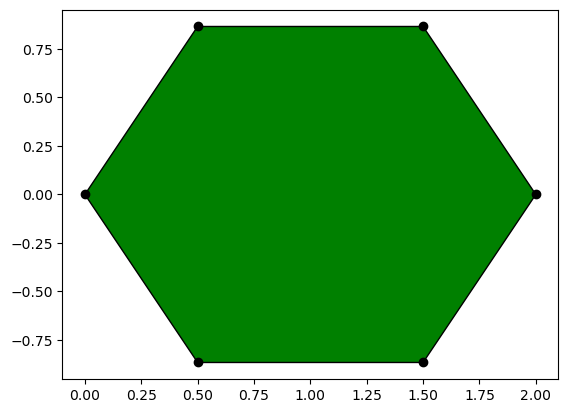

In [94]:
hexa = env.shapes[0]

print(hexa.mesh.face)

print(hexa.mesh.face_normal(28))

vertices = [hexa.mesh.vertex_coordinates(i) for i in hexa.mesh.face[22]]


fig, ax = plt.subplots()
vertices = np.array(vertices)

ax.fill(vertices[:, 0], vertices[:, 2], '+', edgecolor='k', facecolor='green')
ax.scatter(vertices[:, 0], vertices[:, 2], color='k')

# ax.text(b.position[0], b.position[2], i, ha="center", va="center", color="w")

In [102]:
hexa2 = [*env.assembly_env.cra_assembly.blocks()][1]
hexa2.face


{22: [11, 7, 5, 2, 3, 10],
 23: [11, 10, 8, 9],
 24: [6, 7, 11, 9],
 25: [10, 3, 1, 8],
 28: [8, 1, 0, 4, 6, 9],
 29: [5, 7, 6, 4],
 30: [0, 2, 5, 4],
 31: [1, 3, 2, 0]}

In [1]:
from compas_robots import RobotModel
from compas_robots.resources import LocalPackageMeshLoader

from compas.geometry import Frame, Translation, Rotation, Quaternion, Box, Scale
from compas.datastructures import Mesh

from matplotlib import pyplot as plt
import numpy as np

from compas.geometry import Polyhedron

In [47]:
# robot = RobotModel.from_urdf_file('../assembly_gym/shapes/trapezoid.urdf')
# robot.load_geometry(LocalPackageMeshLoader('../assembly_gym/shapes/', 'blocks'))
# print(robot)
# robot.scale(500)

# mesh = robot.links[0].collision[0].geometry.shape.meshes[0]
# print(mesh)

# # scale mesh
# scale = 20
# mesh.transform(Scale.from_factors([scale, scale, scale]))
# print(mesh)
# mesh.to_stl('test.stl')
# print([mesh.vertex_coordinates(v) for v in mesh.vertices()])

Exception: Unable to load meshes for package://blocks/trapezoid.stl

In [38]:


robot.to_urdf_string('test.urdf')

b'<?xml version="1.0" encoding="utf-8"?>\n<robot name="block_t">\n  <link name="block_t_base_link" concave="no">\n    <visual>\n      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>\n      <geometry>\n        <mesh filename="package://blocks/trapezoid.stl"/>\n      </geometry>\n      <material name="blockmat">\n        <color rgba="0.0 0.0 1.0 1.0"/>\n      </material>\n    </visual>\n    <collision>\n      <origin xyz="0.0 0.0 0.0" rpy="0.0 0.0 0.0"/>\n      <geometry>\n        <mesh filename="package://blocks/trapezoid.stl"/>\n      </geometry>\n    </collision>\n    <inertial>\n      <mass value="10.0"/>\n      <inertia ixx="0.4" ixy="0.0" ixz="0.0" iyy="0.4" iyz="0.0" izz="0.2"/>\n    </inertial>\n    <contact>\n      <lateral_friction value="0.7"/>\n      <spinning_friction value=".001"/>\n    </contact>\n  </link>\n</robot>\n'

In [45]:
obot = RobotModel.from_urdf_file('../assembly_gym/shapes/trapezoid.urdf')
robot.load_geometry(LocalPackageMeshLoader('../assembly_gym/shapes/', 'blocks'))
print(robot)


mesh = robot.links[0].collision[0].geometry.shape.meshes[0]
print(mesh)

# scale mesh
print(mesh)
print([mesh.vertex_coordinates(v) for v in mesh.vertices()])

Robot name=block_t, Links=1, Joints=0 (0 configurable)
<Mesh with 8 vertices, 12 faces, 18 edges>
<Mesh with 8 vertices, 12 faces, 18 edges>
[[-0.5000000074505806, -0.5000000074505806, 0.4330126941204071], [-1.0000000149011612, -0.5000000074505806, -0.4330126941204071], [1.0000000149011612, -0.5000000074505806, -0.4330126941204071], [0.5000000074505806, -0.5000000074505806, 0.4330126941204071], [-1.0000000149011612, 0.5000000074505806, -0.4330126941204071], [1.0000000149011612, 0.5000000074505806, -0.4330126941204071], [0.5000000074505806, 0.5000000074505806, 0.4330126941204071], [-0.5000000074505806, 0.5000000074505806, 0.4330126941204071]]


In [2]:
trap = Mesh.from_stl('../assembly_gym/shapes/blocks/trapezoid.stl')

In [66]:
vertices = [trap.vertex_coordinates(v) for v in trap.vertices()]

for v in trap.vertices():
    v = trap.vertex_coordinates(v)
    print(v)
    if v[2] > 0.5:
        v[2] = -v[2]
        vertices.append(v)


# for i in trap.vertices():
#     v = trap.vertex_coordinates(i)
#     if v[0] > 0.5:
#         print(trap.vertex_coordinates(i))

[0.5, 0.0, 0.8660253882408142]
[0.0, 0.0, 0.0]
[2.0, 0.0, 0.0]
[1.5, 0.0, 0.8660253882408142]
[0.0, 1.0, 0.0]
[2.0, 1.0, 0.0]
[1.5, 1.0, 0.8660253882408142]
[0.5, 1.0, 0.8660253882408142]


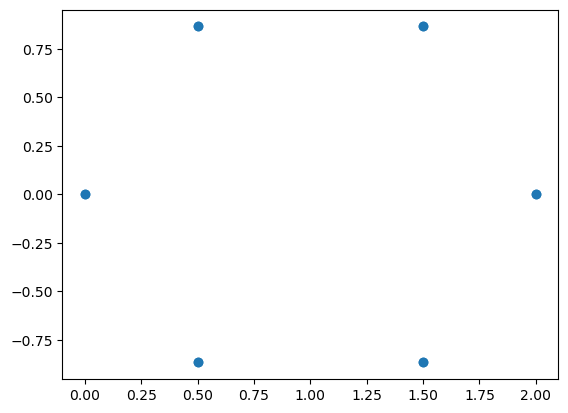

In [62]:
# plot first and last coordinate of the trapezoid

fig, ax = plt.subplots(1, 1)

ax.plot([v[0] for v in vertices], [v[2] for v in vertices], 'o')

In [67]:
# face1a = []
# face1b = []
# face2a = []
# face2b = []
# face3 = []
# face4 = []

# face5 = []
# face6 = []
# face7 = []
# face8 = []

# for i, v in enumerate(vertices):
#     if v[1] > 0.5:
#         if v[2] > -0.5:
#             face1a.append(i)
#         if v[2] < 0.5:
#             face1b.append(i)
#     else:
#         if v[2] > -0.5:
#             face2a.append(i)
#         if v[2] < 0.5:
#             face2b.append(i)

#     if v[2] > 0.5:
#         face3.append(i)

#     if v[2] < -0.5:
#         face4.append(i)

#     if v[0] < 1 and v[2] > -0.5:
#         face5.append(i)

#     if v[0] > 1 and v[2] > -0.5:
#         face6.append(i)

#     if v[0] < 1 and v[2] < 0.5:
#         face7.append(i)

#     if v[0] > 1 and v[2] < 0.5:
#         face8.append(i)



# faces = [face1a, face1b, face2a, face2b, face3, face4, face5, face6, face7, face8]



# for f in faces:
#     print(f, len(f))

# import compas.geometry


# faces = compas.geometry.convex_hull(vertices)

# shift vertices by np.sqrt(3)/2 in the last coordinate
import compas.geometry


for v in vertices:
    v[2] += np.sqrt(3)/2


vertices, faces = compas.geometry.convex_hull_numpy(vertices)
# poly = Polyhedron.from_convex_hull(vertices)

# # hexagon = Mesh.from_vertices_and_faces(*poly.to_vertices_and_faces())

hexagon = Mesh.from_vertices_and_faces(vertices, faces)
# poly.to_vertices_and_faces()

TypeError: cannot unpack non-iterable numpy.int32 object

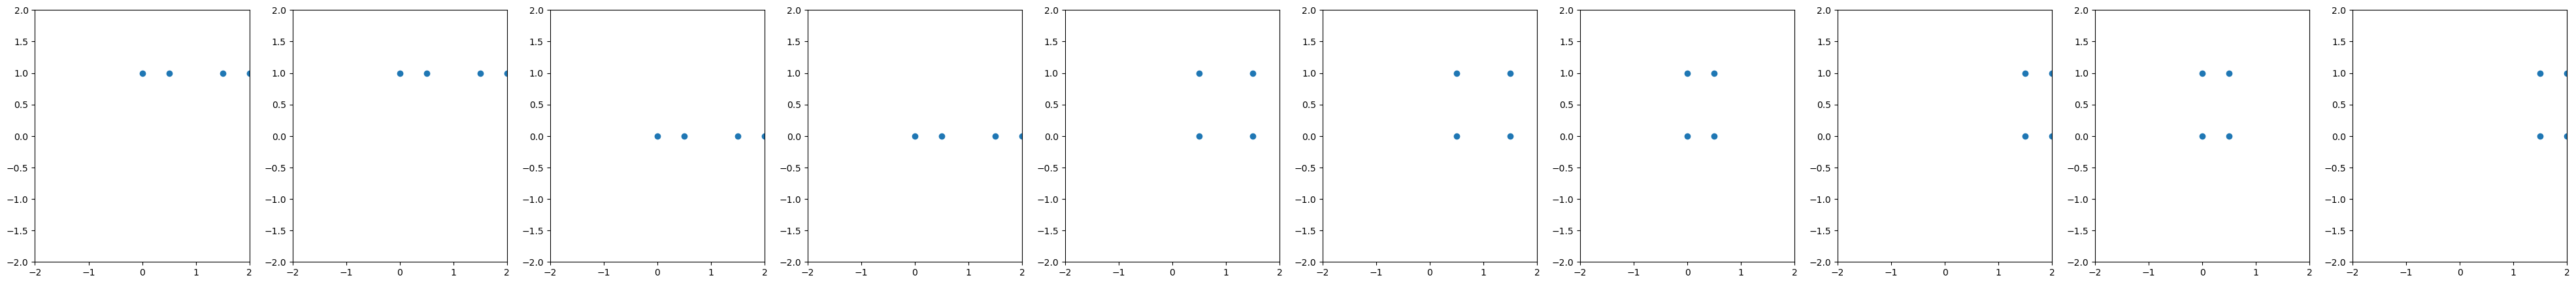

In [50]:
fig, axes = plt.subplots(1, len(faces), figsize=(5*len(faces), 5))

for ax, f in zip(axes, faces):
    vs = [vertices[i] for i in f]  
    ax.plot([v[0] for v in vs], [v[1] for v in vs], 'o')

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)

# plot first and last coordinate of the trapezoi


In [56]:
# shift vertices by np.sqrt(3)/2 in the last coordinate
for v in vertices:
    v[2] += np.sqrt(3)/2

In [68]:
hexagon.to_stl('../assembly_gym/shapes/blocks/hexagon.stl', binary=True)

In [104]:
compas.geometry.intersection_mesh_mesh(hexagon, trap)

PluginNotInstalledError: 

In [3]:
trap.centroid()

[1.0, 0.5, 0.35957138088359175]

In [7]:
from compas_fab.robots import Inertia

In [8]:
Inertia.calculate_inertia_tensor(trap)

TypeError: Inertia.calculate_inertia_tensor() missing 1 required positional argument: 'mesh'

[[-0.5, -0.5, 0.5], [-0.5, -0.5, -0.5], [0.5, -0.5, -0.5], [0.5, -0.5, 0.5], [-0.5, 0.5, -0.5], [0.5, 0.5, -0.5], [0.5, 0.5, 0.5], [-0.5, 0.5, 0.5]]


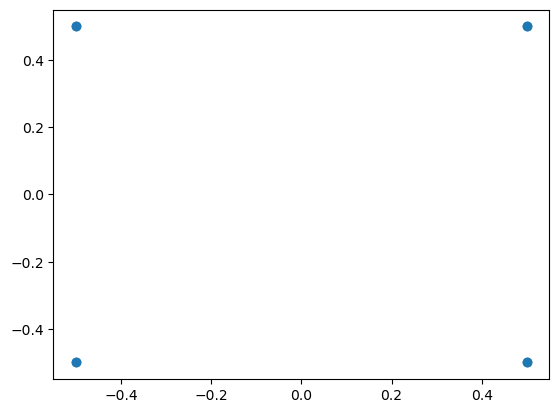

In [13]:
from compas.datastructures import Mesh
import matplotlib.pyplot as plt
import numpy as np
mesh = Mesh.from_stl('../assembly_gym/shapes/blocks/cube_small2.stl')
mesh



# 2d plot
fig, ax = plt.subplots(1, 1)

vertices = [mesh.vertex_coordinates(v) for v in mesh.vertices()]

for v in mesh.vertex.values():
    v["x"] = np.sign(v["x"]) * 0.5
    v["y"] = np.sign(v["y"]) * 0.5
    v["z"] = np.sign(v["z"]) * 0.5
vertices = [mesh.vertex_coordinates(v) for v in mesh.vertices()]
print(vertices)
ax.plot([v[0] for v in vertices], [v[2] for v in vertices], 'o')

In [15]:
centroid = mesh.centroid()
# print(centroid)

# for v in mesh.vertices():
#     mesh.vertex[v]['x'] -= centroid[0]
#     mesh.vertex[v]['y'] -= centroid[1]
#     mesh.vertex[v]['z'] -= centroid[2]

mesh.to_stl('../assembly_gym/shapes/blocks/cube.stl', binary=True)